In [173]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from metadPy.sdt import rates, dprime, criterion
from metadPy.utils import trials2counts, discreteRatings
from scipy.stats import norm
import seaborn as sns
import numpy as np
import pingouin as pg
from systole.detection import oxi_peaks, rr_artefacts
from scipy.stats import pearsonr

sns.set_context('talk')

Import and merge summary statistics

In [174]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
behavior_df = pd.read_csv(path + '/data/behavior.txt')
metadprime_df = pd.read_csv(path + '/data/metadprime.txt')
bayesPsycho_df = pd.read_csv(path + '/data/bayesianPsychophysic.txt')

In [175]:
bayesPsycho_df = bayesPsycho_df[['Subject', 'Condition', 'BayesianThreshold', 'BayesianSlope']]

behavior_df = behavior_df[behavior_df.Session=='Del1']
behavior_df = behavior_df[['Confidence', 'Criterion', 'DecisionRT', 'Modality', 'Subject', 'dPrime']]
behavior_df.rename(columns={'Modality':'Condition'}, inplace=True)

metadprime_df = metadprime_df[['mean', 'Subject', 'Condition']]
metadprime_df.rename(columns={'mean':'meta-d'}, inplace=True)

In [176]:
summary_df = pd.merge(bayesPsycho_df, behavior_df, on=['Subject', 'Condition']).merge(metadprime_df, on=['Subject', 'Condition'])

# Correlation matrice

## Merging data

In [177]:
extero = summary_df[summary_df.Condition=='Extero']
intero = summary_df[summary_df.Condition=='Intero']

intero.drop(['Condition'], axis=1, inplace=True)
intero.rename(columns={'BayesianThreshold':'Interoception - Threshold',
                       'BayesianSlope': 'Interoception - Slope',
                       'Confidence': 'Interoception - Confidence',
                       'Criterion': 'Interoception - Criterion',
                       'DecisionRT': 'Interoception - RT',
                       'dPrime': 'Interoception - d\'',
                       'meta-d': 'Interoception - meta-d\''}, inplace=True)
extero.drop(['Condition'], axis=1, inplace=True)
extero.rename(columns={'BayesianThreshold':'Exteroception - Threshold',
                       'BayesianSlope': 'Exteroception - Slope',
                       'Confidence': 'Exteroception - Confidence',
                       'Criterion': 'Exteroception - Criterion',
                       'DecisionRT': 'Exteroception - RT',
                       'dPrime': 'Exteroception - d\'',
                       'meta-d': 'Exteroception - meta-d\''}, inplace=True)
summary_df = pd.merge(extero, intero, on=['Subject'])

summary_df['Exteroception - m-ratio'] = summary_df['Exteroception - meta-d\'']/summary_df['Exteroception - d\'']
summary_df['Interoception - m-ratio'] = summary_df['Interoception - meta-d\'']/summary_df['Interoception - d\'']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Reorder columns

In [178]:
summary_df = summary_df[
['Subject', 
  'Exteroception - Threshold',
  'Exteroception - Slope',
  'Exteroception - d\'', 
  'Exteroception - Criterion',
  'Exteroception - RT', 
  'Exteroception - Confidence', 
  'Exteroception - meta-d\'',
  'Exteroception - m-ratio',
  'Interoception - Threshold', 
  'Interoception - Slope',
  'Interoception - d\'', 
  'Interoception - Criterion',
  'Interoception - RT', 
  'Interoception - Confidence', 
  'Interoception - meta-d\'',
  'Interoception - m-ratio']]

## Preprocessing

In [179]:
n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(145, 300, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

corr = summary_df.corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['X', 'Y', 'correlation']

pval = summary_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*summary_df.corr().shape)
pval = pd.melt(pval.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
pval.columns = ['X', 'Y', 'pval']

corr = pd.merge(corr, pval, on=['X', 'Y'])

# Highlight upper triangle
upper_df = summary_df.corr().where(~np.triu(np.ones(summary_df.corr().shape)).astype(np.bool), other='upper')
upper_df = pd.melt(upper_df.reset_index(), id_vars='index')
upper_df.columns = ['X', 'Y', 'upper']

corr = pd.merge(corr, upper_df, on=['X', 'Y'])

# Correct for muli comparisons
h, p = pg.multicomp(corr[corr['upper'] == 'upper']['pval'].to_numpy(), method='fdr_bh')
corr['pval'].loc[corr['upper'] == 'upper'] = p

# Color of non significant results
corr['color'] = corr['correlation'].apply(value_to_color)
corr['color'].loc[corr['pval'] > .05] = 'white'

# Size of non significant results
corr['size'] = corr['correlation'].abs()
corr['size'].loc[corr['pval'] > .05] = 0

# Set color and size for diagonal
corr['size'].loc[corr['X'] == corr['Y']] = .1
corr['color'].loc[corr['X'] == corr['Y']] = 'k'

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## Plot

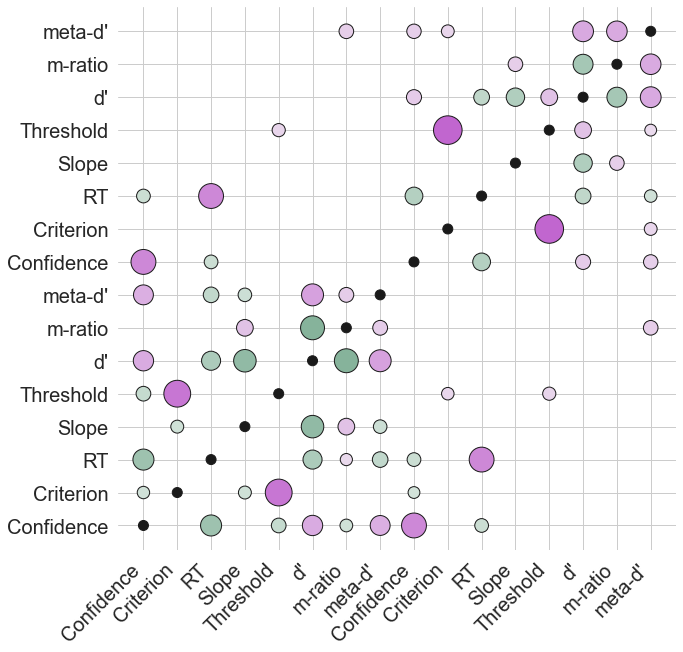

In [180]:
sns.set_theme(style="whitegrid")

def heatmap(x, y, size, color):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 1000
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=color,
        marker='o', # Use square as scatterplot marker
        edgecolors='k',
        label=color,
        cmap='viridis'
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)

    labels = [item.get_text()
          .replace('Interoception - ', '')
          .replace('Exteroception - ', '')for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels, size=20)

    labels = [item.get_text()
          .replace('Interoception - ', '')
          .replace('Exteroception - ', '')for item in ax.get_yticklabels()]
    ax.set_yticklabels(labels, size=20)
    
    #kw = dict(prop="colors", num=10, fmt="$ {x:.2f}",
    #          )
    #legend2 = ax.legend(*scatter.legend_elements(**kw),
    #                    loc='center left', bbox_to_anchor=(1, 0.5), title="Pearson's r")
    sns.despine(left=True, bottom=True)

heatmap(x=corr['X'], y=corr['Y'], size=corr['size'], color=corr['color'])
plt.savefig(path + '/figures/Fig5_heatmap.svg', dpi=300)

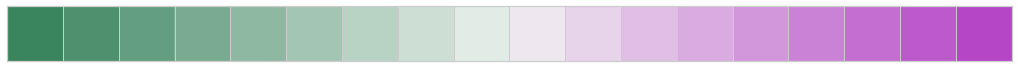

In [158]:
sns.palplot(sns.diverging_palette(145, 300, n=18))
plt.savefig(path + '/figures/Fig5_heatmap_colorbar.svg', dpi=300)

# Skipped correlations

# Inter modality correlation - Threshold

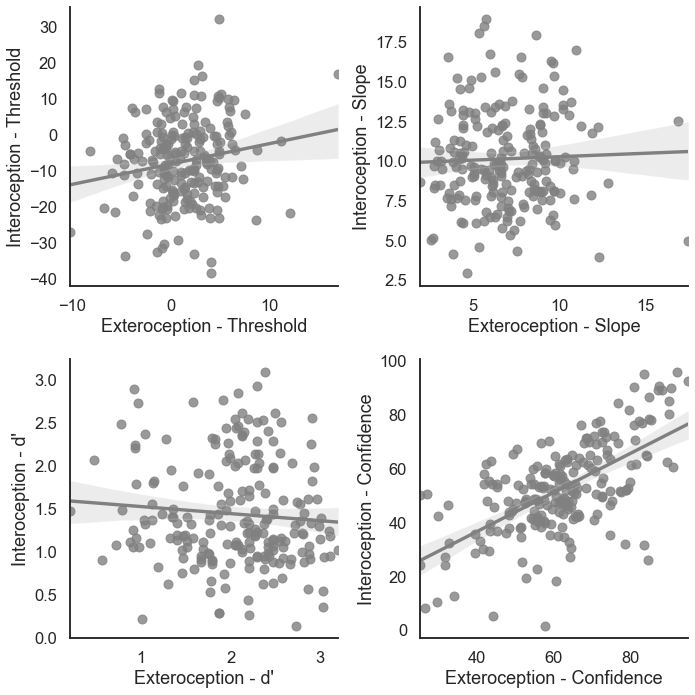

In [159]:
sns.set(style="white", color_codes=True)
sns.set_context('talk')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

sns.regplot(data=summary_df, x='Exteroception - Threshold',
            y='Interoception - Threshold', ax=axs[0, 0], color='gray')

sns.regplot(data=summary_df, x='Exteroception - Slope',
            y='Interoception - Slope', ax=axs[0, 1], color='gray')

sns.regplot(data=summary_df, x='Exteroception - d\'',
            y='Interoception - d\'', ax=axs[1, 0], color='gray')

sns.regplot(data=summary_df, x='Exteroception - Confidence',
            y='Interoception - Confidence', ax=axs[1, 1], color='gray')

plt.tight_layout()
sns.despine()
plt.savefig(path + '/figures/Fig5_SkippedCorrelations.svg', dpi=300)

In [183]:
pg.corr(x=summary_df['Exteroception - Threshold'].to_numpy(),
        y=summary_df['Interoception - Threshold'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,212,7,0.125074,"[-0.01, 0.26]",0.015643,0.006224,0.073961,0.444945


In [161]:
pg.corr(x=summary_df['Exteroception - Slope'].to_numpy(),
        y=summary_df['Interoception - Slope'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,212,6,0.061465,"[-0.07, 0.19]",0.003778,-0.005755,0.38013,0.144752


In [162]:
pg.corr(x=summary_df['Exteroception - d\''].to_numpy(),
        y=summary_df['Interoception - d\''].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,212,2,-0.082519,"[-0.21, 0.05]",0.006809,-0.002695,0.233771,0.223789


In [163]:
pg.corr(x=summary_df['Exteroception - Confidence'].to_numpy(),
        y=summary_df['Interoception - Confidence'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,212,4,0.547918,"[0.45, 0.64]",0.300214,0.293517,1.077635e-17,1.0


# Correlations with the Heartbeat Counting task

In [195]:
sns.set(style="white", color_codes=True)
sns.set_context('talk')

In [196]:
behavior_df = pd.read_csv(path + '/data/behavior.txt')
behavior_df = behavior_df[behavior_df.Session=='Del1']
behavior_df.rename(columns={'Modality':'Condition'}, inplace=True)
summary_df = pd.merge(bayesPsycho_df, behavior_df, on=['Subject', 'Condition'])

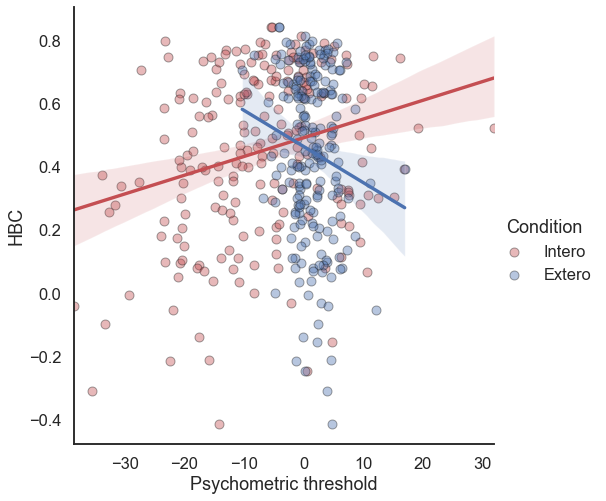

In [197]:
sns.lmplot(data=summary_df, x='BayesianThreshold', y='HBC', hue='Condition', 
           palette=['#c44e52', '#4c72b0'], height=7, robust=True,
           scatter_kws={'alpha':.4, 'edgecolors': 'k'})
plt.xlabel('Psychometric threshold')
plt.savefig(path + '/figures/Fig6_HBC_corr.svg', dpi=300)

In [206]:
pg.corr(x=summary_df['BayesianThreshold'][summary_df.Condition=='Intero'].to_numpy(),
        y=summary_df['HBC'][summary_df.Condition=='Intero'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,206,8,0.228826,"[0.1, 0.35]",0.052361,0.043025,0.001184,0.914087


In [204]:
pg.corr(x=summary_df['BayesianThreshold'][summary_df.Condition=='Extero'].to_numpy(),
        y=summary_df['HBC'][summary_df.Condition=='Extero'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,206,8,-0.065158,"[-0.2, 0.07]",0.004246,-0.005565,0.361758,0.153724


In [207]:
pg.corr(x=summary_df['BayesianThreshold'][summary_df.Condition=='Intero'].to_numpy(),
        y=summary_df['BayesianThreshold'][summary_df.Condition=='Extero'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,213,6,0.113232,"[-0.02, 0.24]",0.012822,0.00342,0.104271,0.378896


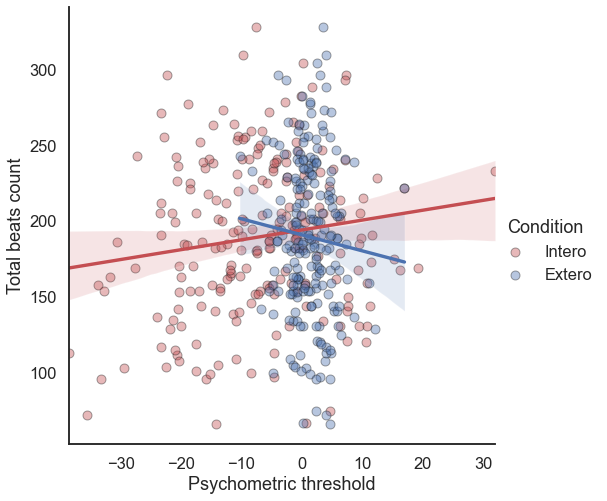

In [200]:
sns.lmplot(data=summary_df, x='BayesianThreshold', y='HBC_total', hue='Condition', 
           palette=['#c44e52', '#4c72b0'], height=7, robust=True,
           scatter_kws={'alpha':.4, 'edgecolors': 'k'})
plt.ylabel('Total beats count')
plt.xlabel('Psychometric threshold')
plt.savefig(path + '/figures/Fig6_HBC_corr2.svg', dpi=300)

In [201]:
pg.corr(x=summary_df['BayesianThreshold'][summary_df.Condition=='Intero'].to_numpy(),
        y=summary_df['HBC_total'][summary_df.Condition=='Intero'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,213,1,0.112334,"[-0.02, 0.24]",0.012619,0.003215,0.102867,0.37389


In [202]:
pg.corr(x=summary_df['BayesianThreshold'][summary_df.Condition=='Extero'].to_numpy(),
        y=summary_df['HBC_total'][summary_df.Condition=='Extero'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,213,5,-0.019283,"[-0.15, 0.12]",0.000372,-0.009148,0.7822,0.058954
